In [11]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sb
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# load the dataset (Train, Test)

In [12]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
print(train_data.head(3))
train_y = train_data['Survived']
train_X = train_data.drop(columns= ['Survived'])
print("Train data: ", train_X.head(3))
print("Train data: ", train_data.describe())

test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
# test data does not have survived
print("Test data: ", test_data.head(3))

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
Train data:     PassengerId  Pclass                                               Name  \
0            1       3                            Braund, Mr. Owen Harris   
1            2       1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
2            3       3                             Heikkinen, Miss. Laina   

      Sex   

In [13]:
# Explore dataset
print(train_data.info())
print(train_data.columns)
train_data.sample(3)

# find missing values
def display_missing(df):
    for col in df.columns.tolist():
        print('{} column missing value: {}'.format(col, df[col].isnull().sum()))

display_missing(train_data)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
PassengerId column missing value: 0
Survived column missing value: 0
Pclass column mis

In [14]:
# fill up Age with Median? 
# look at the correlation coefficient
combined = pd.concat([train_data, test_data]).reset_index()
df_all_corr = combined.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_all_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
print(df_all_corr[df_all_corr['Feature 1'] == 'Age'])


age_by_pclass_sex = combined.groupby(['Sex', 'Pclass']).median()['Age']

for pclass in range(1, 4):
    for sex in ['female', 'male']:
        print('Median age of Pclass {} {}s: {}'.format(pclass, sex, age_by_pclass_sex[sex][pclass]))
print('Median age of all passengers: {}'.format(combined['Age'].median()))

# Filling the missing values in Age with the medians of Sex and Pclass groups
combined['Age'] = combined.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

   Feature 1    Feature 2  Correlation Coefficient
4        Age          Age                 1.000000
11       Age       Pclass                 0.408106
19       Age        SibSp                 0.243699
22       Age         Fare                 0.178740
29       Age        Parch                 0.150917
32       Age     Survived                 0.077221
44       Age  PassengerId                 0.028814
53       Age        index                 0.012723
Median age of Pclass 1 females: 36.0
Median age of Pclass 1 males: 42.0
Median age of Pclass 2 females: 28.0
Median age of Pclass 2 males: 29.5
Median age of Pclass 3 females: 22.0
Median age of Pclass 3 males: 25.0
Median age of all passengers: 28.0


Classification - What should I use?

In [15]:
# exploring the patterns - male, female
women = train_data.loc[train_data.Sex == 'female']["Survived"]
rate_women = sum(women)/len(women)

print("% of women who survived:", rate_women)

men = train_data.loc[train_data.Sex == 'male']["Survived"]
rate_men = sum(men)/len(men)

print("% of men who survived:", rate_men)

# exploring the patterns - age
mean_age = train_data['Age'].mean()
print("mean age: ", mean_age)
above_mean_age = train_data.loc[train_data.Age >= 60]["Survived"]
rate_above_mean_age = sum(above_mean_age)/len(above_mean_age)
print("% of person age above 60 survived", rate_above_mean_age)
below_mean_age = train_data.loc[train_data.Age <= 19]["Survived"]
rate_below_mean_age = sum(below_mean_age)/len(below_mean_age)
print("% of person age below 19 survived", rate_below_mean_age)

% of women who survived: 0.7420382165605095
% of men who survived: 0.18890814558058924
mean age:  29.69911764705882
% of person age above 60 survived 0.2692307692307692
% of person age below 19 survived 0.4817073170731707


In [16]:
# Feature Embark
# missing values are filled with S as google search informed
print(combined[combined['Embarked'].isnull()])
combined['Embarked'] = combined['Embarked'].fillna('S')
#combined['Embarked'] = combined['Embarked'].fillna('C')

# Feature Fare
# only one passenger missing Fare value 
med_fare = combined.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]
# Filling the missing value in Fare with the median Fare of 3rd class alone passenger
combined['Fare'] = combined['Fare'].fillna(med_fare)

# Feature Cabin
# in this example, exploring Cabin seems overreach, as there are a lot of missing values for cabin
print("Missing Cabin Values")
print(combined[combined['Cabin'].isnull()].shape)

combined = combined.drop(['Cabin'], axis=1)
print("After dropping Cabin Column: ")
print(combined.shape)

     index  PassengerId  Survived  Pclass  \
61      61           62       1.0       1   
829    829          830       1.0       1   

                                          Name     Sex   Age  SibSp  Parch  \
61                         Icard, Miss. Amelie  female  38.0      0      0   
829  Stone, Mrs. George Nelson (Martha Evelyn)  female  62.0      0      0   

     Ticket  Fare Cabin Embarked  
61   113572  80.0   B28      NaN  
829  113572  80.0   B28      NaN  
Missing Cabin Values
(1014, 13)
After dropping Cabin Column: 
(1309, 12)


In [17]:
# Missing Value Check
df_train, df_test = combined.loc[:890], combined.loc[891:].drop(['Survived'], axis=1)
dfs = [df_train, df_test]

for df in dfs:
    display_missing(df)

index column missing value: 0
PassengerId column missing value: 0
Survived column missing value: 0
Pclass column missing value: 0
Name column missing value: 0
Sex column missing value: 0
Age column missing value: 0
SibSp column missing value: 0
Parch column missing value: 0
Ticket column missing value: 0
Fare column missing value: 0
Embarked column missing value: 0
index column missing value: 0
PassengerId column missing value: 0
Pclass column missing value: 0
Name column missing value: 0
Sex column missing value: 0
Age column missing value: 0
SibSp column missing value: 0
Parch column missing value: 0
Ticket column missing value: 0
Fare column missing value: 0
Embarked column missing value: 0


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


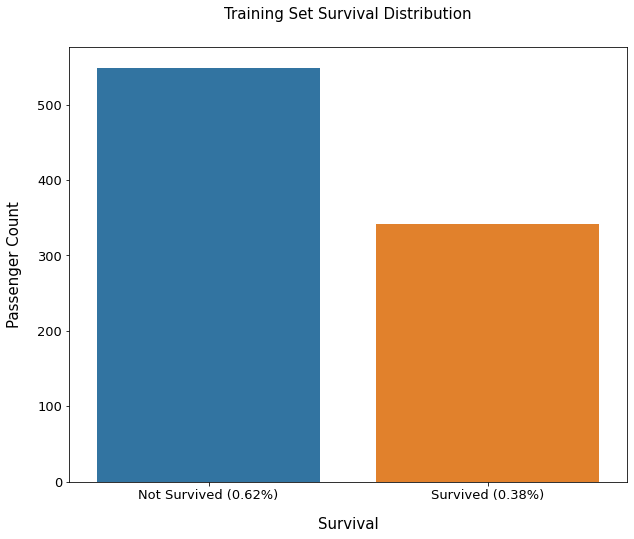

In [18]:
# Target Distribution:
survived = df_train['Survived'].value_counts()[1]
not_survived = df_train['Survived'].value_counts()[0]

plt.figure(figsize=(10, 8))
sb.countplot(df_train['Survived'])

plt.xlabel('Survival', size=15, labelpad=15)
plt.ylabel('Passenger Count', size=15, labelpad=15)
plt.xticks((0, 1), ['Not Survived ({0:.2f}%)'.format(not_survived/df_train['Survived'].shape[0]), 'Survived ({0:.2f}%)'.format(survived/df_train['Survived'].shape[0])])
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)

plt.title('Training Set Survival Distribution', size=15, y=1.05)

plt.show()

In [19]:
# Correlations
df_train_corr = df_train.drop(['PassengerId'], axis=1).corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_train_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_train_corr.drop(df_train_corr.iloc[1::2].index, inplace=True)
df_train_corr_nd = df_train_corr.drop(df_train_corr[df_train_corr['Correlation Coefficient'] == 1.0].index)

df_test_corr = df_test.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_test_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_test_corr.drop(df_test_corr.iloc[1::2].index, inplace=True)
df_test_corr_nd = df_test_corr.drop(df_test_corr[df_test_corr['Correlation Coefficient'] == 1.0].index)

# Training set high correlations
corr = df_train_corr_nd['Correlation Coefficient'] > 0.1
df_train_corr_nd[corr]

,Feature 1,Feature 2,Correlation Coefficient
8,Pclass,Fare,0.549500
10,Pclass,Age,0.417667
12,SibSp,Parch,0.414838
14,Pclass,Survived,0.338481
16,Fare,Survived,0.257307
18,Age,SibSp,0.249747
20,Parch,Fare,0.216225
22,Age,Parch,0.176733
24,Fare,SibSp,0.159651
26,Age,Fare,0.124061


In [20]:
# Test set high correlations
corr = df_test_corr_nd['Correlation Coefficient'] > 0.1
df_test_corr_nd[corr]

,Feature 1,Feature 2,Correlation Coefficient
10,Fare,Pclass,0.577489
12,Age,Pclass,0.526789
14,Age,Fare,0.345347
16,SibSp,Parch,0.306895
18,Parch,Fare,0.230410
20,SibSp,Fare,0.172032


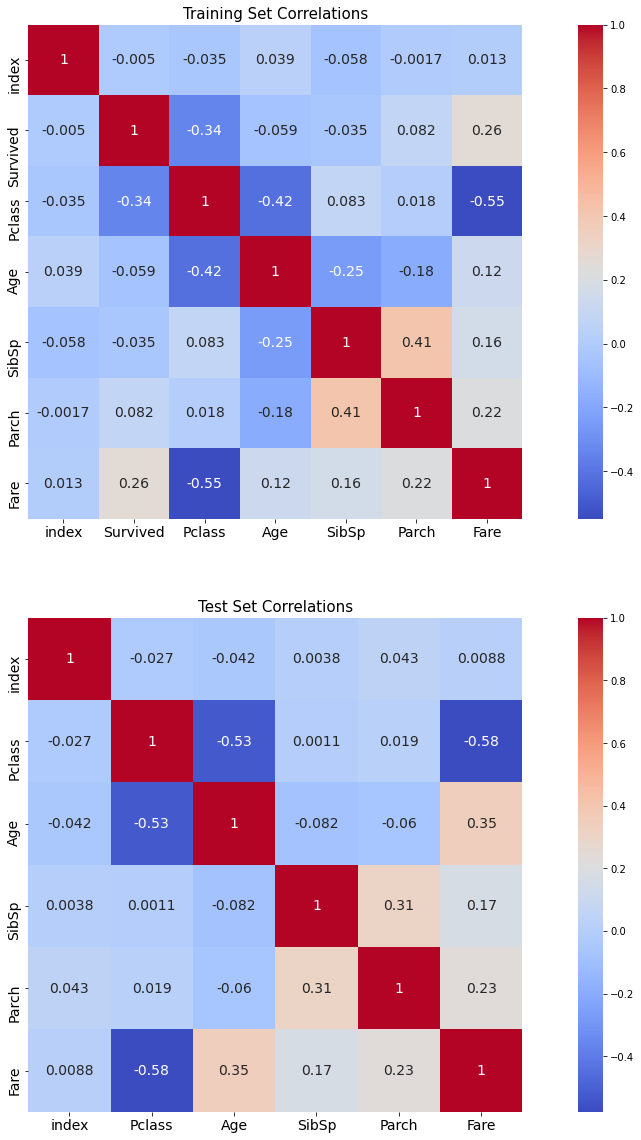

In [22]:
fig, axs = plt.subplots(nrows=2, figsize=(20, 20))

sb.heatmap(df_train.drop(['PassengerId'], axis=1).corr(), ax=axs[0], annot=True, square=True, cmap='coolwarm', annot_kws={'size': 14})
sb.heatmap(df_test.drop(['PassengerId'], axis=1).corr(), ax=axs[1], annot=True, square=True, cmap='coolwarm', annot_kws={'size': 14})

for i in range(2):    
    axs[i].tick_params(axis='x', labelsize=14)
    axs[i].tick_params(axis='y', labelsize=14)
    
axs[0].set_title('Training Set Correlations', size=15)
axs[1].set_title('Test Set Correlations', size=15)

plt.show()

In [ ]:
# model


In [ ]:
'''
# using logistic regression for classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
# from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, plot_roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
import matplotlib.pyplot as plt

y = train_data["Survived"]
trainX = train_data.drop(['Name', 'Ticket', 'Cabin', 'Embarked', 'Survived', 'PassengerId', 'Parch', 'SibSp'], axis=1)
#trainX.replace('S', 1, inplace=True)
#trainX.replace('C', 0, inplace=True)

trainX.replace('male', 1, inplace=True)
trainX.replace('female', 0, inplace=True)
print(trainX.head())
model = LogisticRegression()
trainX_nr = StandardScaler().fit_transform(trainX)
# print(trainX_nr)

scaler = MinMaxScaler()
trainX_mm = scaler.fit_transform(trainX)
print(trainX_mm)
# trainX_mm.replace('nan', 1, inplace=True)
col_mean = np.nanmean(trainX_mm, axis=0)
print(col_mean)

#Find indices that you need to replace
inds = np.where(np.isnan(trainX_mm))

#Place column means in the indices. Align the arrays using take
trainX_mm[inds] = np.take(col_mean, inds[1])

model.fit(trainX_mm, y)

# train data
yPred_tr = model.predict(trainX_mm)
cm = confusion_matrix(y, yPred_tr)
print("train cm = ", cm)
print(classification_report(y, yPred_tr))
auc_tr = roc_auc_score(list(y), list(yPred_tr))
print("traing auc:", auc_tr)
fpr, tpr, thresholds = roc_curve(list(y), list(yPred_tr))
print("fpr: ", fpr)
print("tpr: ", tpr)
print("th: ", thresholds)
plot_roc_curve(model, trainX_mm, y)
plt.show()

logit_model=sm.OLS(y,trainX_mm)
result=logit_model.fit()
print(result.summary())

testX = test_data.drop(['Name', 'Ticket', 'Cabin', 'Embarked', 'PassengerId', 'Parch', 'SibSp'], axis=1)
testX.replace('male', 1, inplace=True)
testX.replace('female', 0, inplace=True)

testX_mm = scaler.fit_transform(testX)
print(testX_mm)
# trainX_mm.replace('nan', 1, inplace=True)
col_mean = np.nanmean(testX_mm, axis=0)
print(col_mean)

#Find indices that you need to replace
inds = np.where(np.isnan(testX_mm))

#Place column means in the indices. Align the arrays using take
testX_mm[inds] = np.take(col_mean, inds[1])

predictions = model.predict(testX_mm)
# print(predictions)

print("Score with logistic regression is 0.76")
'''

In [ ]:
'''
# using Decision Tree, Random Forest
from sklearn.ensemble import RandomForestClassifier

y = train_data["Survived"]


features = ["Pclass", "Sex", "SibSp", "Parch"]
X = pd.get_dummies(train_data[features])
X_test = pd.get_dummies(test_data[features])

model = RandomForestClassifier(n_estimators=3000, max_depth=5, random_state=1)
model.fit(X, y)
predictions = model.predict(X_test)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

# result
print("score is 0.77")
'''

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

y = train_data["Survived"]
features = ["Pclass", "Sex", "SibSp", "Parch"]
X = pd.get_dummies(train_data[features])
X_test = pd.get_dummies(test_data[features])

model = XGBClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f'%(np.mean(n_scores)))

model.fit(X,y)
predictions = model.predict(X_test)
print(predictions)

In [ ]:
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")